# Notebook 0: Data preprocessing
Historic data for models training originates from Iowa State University web page and is accessible under this link: 
https://mesonet.agron.iastate.edu/request/download.phtml?network=PL__ASOS

Notebook consists of two sections - for LSTM model and XGBoost algorithm.
# Data from Łódź for LSTM model
Preprocessing of weather data followed by the division into training, validation, and testing sets.

## Weather data description
Data for LSTM models include weather parameters from 2010-12-01 00:00 to 2022-12-30 23:30 such as:
- station - name of station where data has been collected, here EPLL - station located in Łódź,
- valid	- timestamp when data has been collected
- tmpc - air temperature in Celsius degree, 
- relh - relative humidity in percentage, 
- sknt - speed of wind in knots.

LSTM model will be fed with historical measurements from Łódź city such as:
- temperature - in Celsius degree, 
- wind speed  - in kilometers per hour, 
- humidity    - in percentage.

This data with time steps is then necessary for the model to extract.

## All necessary libraries imports

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Files to load and then save extracted data

In [26]:
# file where the whole historical data from Łódź has been collected
file_name = "all_data/data_for_main_model/data_lodz_main_data.csv"
# file where to save data for training
file_name_training = "all_data/data_for_main_model/data_ready_for_training.csv"
# file where to save data for validation
file_name_validation = "all_data/data_for_main_model/data_ready_for_validation.csv"
# file where to save data for testing
file_name_testing = "all_data/data_for_main_model/data_ready_for_testing.csv"

# read the CSV file where the whole historical data from Łódź has been collected
all_data = pd.read_csv(file_name,dtype={"tmpc":'O',"relh":'O',"sknt":'O'})

# display head of data
all_data.head()

,station,valid,tmpc,relh,sknt
0,EPLL,2010-12-01 00:00,-12.00,92.25,6.00
1,EPLL,2010-12-01 00:30,-13.00,92.19,6.00
2,EPLL,2010-12-01 01:00,-12.00,92.25,10.00
3,EPLL,2010-12-01 01:30,-12.00,92.25,7.00
4,EPLL,2010-12-01 02:00,-12.00,92.25,6.00


## Empty cells in data table extraction
In the given dataset empty cells has been marked with 'M' values.

In [27]:
# drop station column
df = all_data[["valid", "tmpc", "relh", "sknt"]]

# replacing 'M' values with nan values
df=df.replace('M', np.nan)

# number of nan values in each column
df.isna().mean()

valid    0.000000
tmpc     0.000030
relh     0.000449
sknt     0.000010
dtype: float64

For each nan value:
- The same data as in previous step is taken in 'relh' column (because there are sequences of nan values).
- The mean from previous and next steps in 'tmpc' and 'sknt' is taken.

In [28]:
# change the types of data into float
df['tmpc'] = df['tmpc'].astype(float)
df['relh'] = df['relh'].astype(float)
df['sknt'] = df['sknt'].astype(float)

# 'relh' column - nan value into data from previous timestamp
bool_df = df['relh'].isnull()
indexes = df[bool_df].index
for i in indexes:
    df.loc[i,'relh']=df.loc[i-1,'relh']
# 'tmpc' column - nan value into data from the previous and next timestamp
bool_df = df['tmpc'].isnull()
indexes = df[bool_df].index
for i in indexes:
    df.loc[i,'tmpc']=(df['tmpc'][i-1] + df['tmpc'][i+1])/2

# 'sknt'column : nan value into data from the previous and next timestamp
bool_df = df['sknt'].isnull()
indexes = df[bool_df].index
for i in indexes:
    df.loc[i,'sknt']=(df['sknt'][i-1] + df['sknt'][i+1])/2

# number of nan values in each column
df.isna().mean()

valid    0.0
tmpc     0.0
relh     0.0
sknt     0.0
dtype: float64

## Transformations
Columns in data table rename, speed of wind into kilometers per hour (kmph) conversion and dates into month, year and time division.

In [29]:
# rename column 'tmpc' into 'temp'
df.rename(columns = {'tmpc':'temp'}, inplace = True)

# convert knt into kph
knots_into_kmph = 1.852 
df['skph'] = df['sknt'] * knots_into_kmph
df.drop('sknt',axis='columns', inplace=True)

# dates division and 'valid' column drop 
df['valid']=pd.to_datetime(df['valid'])
df['month'] = df['valid'].dt.month
df['year'] = df['valid'].dt.year
df['time'] = df['valid'].dt.time
df.drop('valid',axis='columns', inplace=True)

# display head of data
df.head(12)

,temp,relh,skph,month,year,time
0,-12.0,92.25,11.112,12,2010,00:00:00
1,-13.0,92.19,11.112,12,2010,00:30:00
2,-12.0,92.25,18.520,12,2010,01:00:00
3,-12.0,92.25,12.964,12,2010,01:30:00
4,-12.0,92.25,11.112,12,2010,02:00:00
5,-12.0,92.25,14.816,12,2010,02:30:00
6,-12.0,92.25,11.112,12,2010,03:00:00
7,-13.0,100.00,14.816,12,2010,03:30:00
8,-13.0,100.00,14.816,12,2010,04:00:00
9,-13.0,100.00,12.964,12,2010,04:30:00


## Checking the number of rows for each year if there is any missing data

In [30]:
# for each year
for year in range(2010, 2023):
    # print year
    print(year)
    # print number of rows
    print(df[df['year'] == year].shape)

2010
(1475, 6)
2011
(6878, 6)
2012
(17323, 6)
2013
(17482, 6)
2014
(17417, 6)
2015
(17426, 6)
2016
(17538, 6)
2017
(17504, 6)
2018
(17505, 6)
2019
(17507, 6)
2020
(17546, 6)
2021
(17493, 6)
2022
(17460, 6)


Each year should include around 17500 rows.

There is a lot of missing rows in 2010 and 2011 year.

In [31]:
# drop of data from 2010 and 2011
df.drop(df[df['year'] == 2010].index, inplace = True)
df.drop(df[df['year'] == 2011].index, inplace = True)

## Data split into training, validation and testing

In [32]:
# data for training 2012 and 2013
df_train = df[(df['year'] == 2012) | (df['year'] == 2013)] 

# data for validation 2014 and 2015
df_valid = df[(df['year'] == 2014) | (df['year'] == 2015)] 

# data for testing 2016, 2017, 2018, 2019, 2020, 2021 and 2022
df_test = df[(df['year'] != 2012) & (df['year'] != 2013) & (df['year'] != 2014) & (df['year'] != 2015)]

Save data into CSV files which names are in the beginning of the notebook in the section "Files to load and then save extracted data".

In [33]:
df_train.to_csv(file_name_training)
df_valid.to_csv(file_name_validation)
df_test.to_csv(file_name_testing)

## Data analysis

Mean of each weather components for training, validation and test sets.

In [34]:
print(f"Mean of relative humidity in training data set: {df_train['relh'].mean()}")
print(f"Mean of relative humidity in valid data set: {df_valid['relh'].mean()}")
print(f"Mean of relative humidity in test data set: {df_test['relh'].mean()}\n")

print(f"Mean of wind speed in training data set: {df_train['skph'].mean()}")
print(f"Mean of wind speed in valid data set: {df_valid['skph'].mean()}")
print(f"Mean of wind speed in test data set: {df_test['skph'].mean()}\n")

print(f"Mean of temperature in training data set: {df_train['temp'].mean()}")
print(f"Mean of temperature in valid data set: {df_valid['temp'].mean()}")
print(f"Mean of temperature in test data set: {df_test['temp'].mean()}")

Mean of relative humidity in training data set: 79.10682057175694
Mean of relative humidity in valid data set: 75.41746376603624
Mean of relative humidity in test data set: 76.37796471730599

Mean of wind speed in training data set: 10.757084326964517
Mean of wind speed in valid data set: 11.062940045346268
Mean of wind speed in test data set: 12.206428891989589

Mean of temperature in training data set: 8.665507829334866
Mean of temperature in valid data set: 10.032115489481388
Mean of temperature in test data set: 9.566897587166368


In [35]:
df

,temp,relh,skph,month,year,time
8353,-2.0,100.00,0.000,1,2012,00:00:00
8354,-2.0,100.00,0.000,1,2012,00:30:00
8355,-2.0,100.00,3.704,1,2012,01:00:00
8356,-2.0,100.00,0.000,1,2012,01:30:00
8357,-3.0,100.00,5.556,1,2012,02:00:00
...,...,...,...,...,...,...
200549,4.0,86.79,7.408,12,2022,21:30:00
200550,4.0,86.79,9.260,12,2022,22:00:00
200551,3.0,93.14,7.408,12,2022,22:30:00
200552,4.0,86.79,11.112,12,2022,23:00:00


Plots showing speed of wind, temperature and relative humidity for time from the beginning of 2012 till the end of 2022.

Text(0.5, 1.0, 'temperature [°C]')

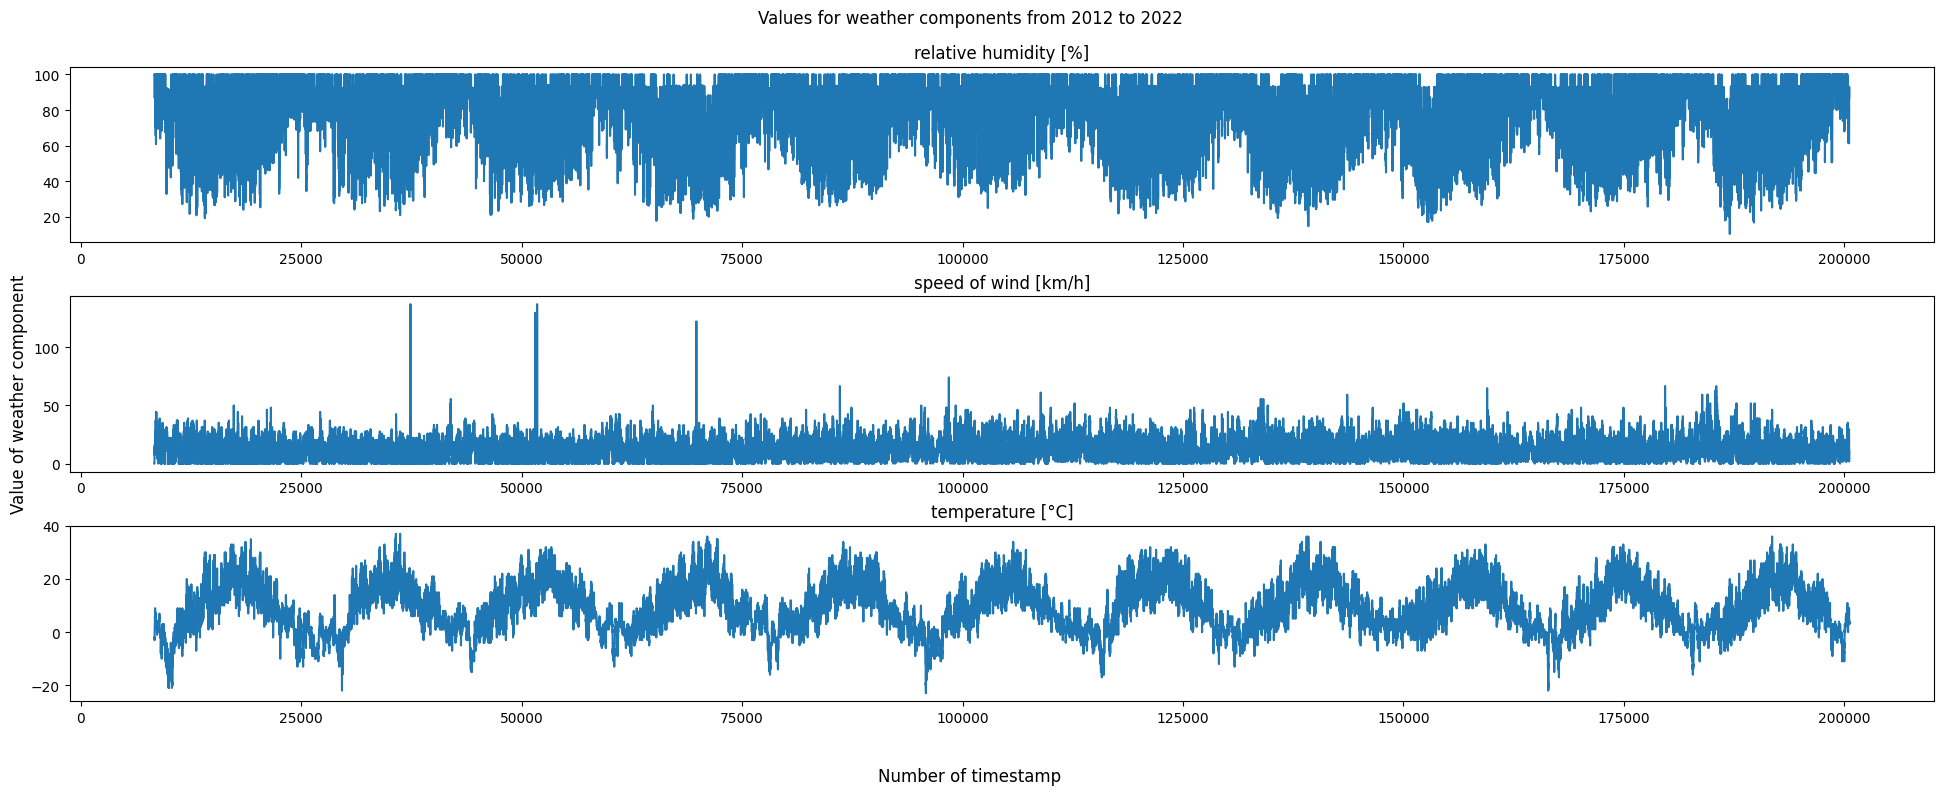

In [54]:
# figure initialize
fig, axs = plt.subplots(3,figsize=(20, 8))
fig.suptitle(
        "Values for weather components from 2012 to 2022"
)
fig.supxlabel('Number of timestamp')
fig.supylabel('Value of weather component')
fig.tight_layout(pad=1.8)

# add data to each subplot
axs[0].plot(df['relh'])
axs[0].set_title("relative humidity [%]")

axs[1].plot(df['skph'])
axs[1].set_title("speed of wind [km/h]")

axs[2].plot(df['temp'])
axs[2].set_title("temperature [°C]")

Variables correlations.

         relh      skph      temp
relh  1.00000 -0.231160 -0.518280
skph -0.23116  1.000000  0.001823
temp -0.51828  0.001823  1.000000


Text(0.5, 1.0, 'Correlation Matrix')

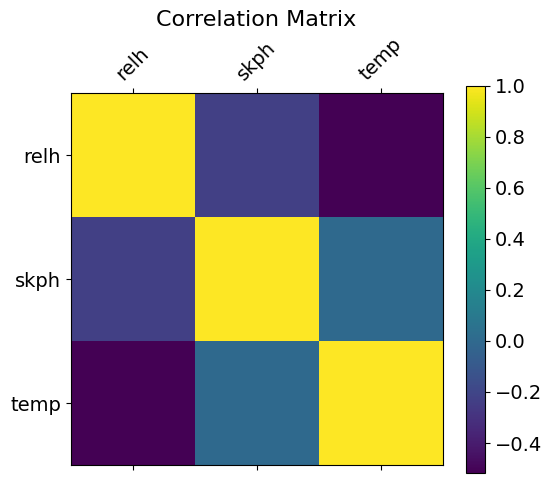

In [37]:
# data to calculate correlations on
df_corr = df[["relh", "skph", "temp"]]
print(df_corr.corr())

# correlations matrix
f = plt.figure(figsize=(6, 5))
plt.matshow(df_corr.corr(), fignum=f.number)
plt.xticks(range(df_corr.select_dtypes(['number']).shape[1]), df_corr.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df_corr.select_dtypes(['number']).shape[1]), df_corr.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In the correlation matrix there is:
- A negative correlation beetwen relative humidity and speed of wind on the level of -0.2.
- A negative correlation beetwen relative humidity and temperature on the level of -0.5.
- A small positive correlation beetwen speed of wind and temperature on the level of 0.002.

Correlations are specific as for the weather components. Relative humidity usually decreas when temperature is growing and sometimes speed of wind is higher. Temperature and speed of wind are not correlated.

# Data for Gdańsk, Kraków, Rzeszów, Szczecin, Warszawa from 2022 and 2023 and for Łódź from 2022
In the similar way as for data from Łódź every dataset with historic data from Gdańsk, Kraków, Rzeszów, Szczecin, Warszawa from 2022-01-01 00:00 to 2023-12-05 17:30 and for Łódź in 2022 has been prepared and saved in all_data/data_distance_drom_Lodz folder in files Gdańsk_2022_2023, Kraków_2022_2023, Rzeszów_2022_2023, Szczecin_2022_2023, Warszawa_2022_2023 and Łódź_2022.

## Data for XGBoost model
Data for XGBoost model has been downloaded from Warszawa, Wrocław, Szczecin and Rzeszów cities, then 'valid' column has been partitioned into some more columns and saved in combined_cities_data_for_xgb.csv file.

It includes weather parameters from 2015-01-01 00:30 to 2022-12-30 23:30 such as:
- station - name of station where data has been collected, here EPLL - station located in Łódź,
- valid	- timestamp when data has been collected
- lon - longtitude value of station where measurements were conducted,
- lat - latitude value of station where measurements were conducted,
- tmpc - air temperature in Celsius degree, 
- relh - relative humidity in percentage, 
- sknt - speed of wind in knots,
- day - day of timestamp,
- month	- month of timestamp,
- year - year of timestamp,
- hour - hour of timestamp,
- minutes - minutes of timestamp.

XGBoost algorithm will be fed with historical measurements as ebove despite 'valid' coumn and with speed of wind converted to [km/h].

## Files to load and then save extracted data

In [38]:
# file where the whole historical data from Gdańsk, Kraków, Rzeszów, Szczecin, Warszawa has been collected
file_name = "all_data/data_for_XGB/combined_cities_data_for_xgb.csv"
# file where to save data for training
file_name_training = "all_data/data_for_XGB/data_ready_for_training.csv"
# file where to save data for validation
file_name_validation = "all_data/data_for_XGB/data_ready_for_validation.csv"
# file where to save data for testing
file_name_testing = "all_data/data_for_XGB/data_ready_for_testing.csv"

# read the CSV file where the whole historical data from Łódź has been collected
data_xgb = pd.read_csv(file_name, delimiter=';',dtype={"relh":'O'})
# drop 'valid' column
data_xgb.drop('valid',axis='columns', inplace=True)

# display head of data
data_xgb.head()

,station,lon,lat,tmpc,relh,sped,day,month,year,hour,minutes
0,EPRZ,22.0200,50.1114,-4.0,79.62,13.80,1,1,2015,0,30
1,EPWR,16.8858,51.1027,2.0,86.59,6.90,1,1,2015,0,30
2,EPWR,16.8858,51.1027,2.0,86.59,6.90,1,1,2015,1,0
3,EPRZ,22.0200,50.1114,-4.0,79.62,12.65,1,1,2015,1,0
4,EPWA,20.9611,52.1628,1.0,93.03,6.90,1,1,2015,1,0


## Empty cells in data table extraction
In the given dataset empty cells has been marked with 'M' values.

In [39]:
# dropping first two values so as to achive the same data for each city - there were two additional rows
filtered = data_xgb[2:].reset_index(drop=True)

# replacing 'M' values with nan values
df_xgb=filtered.replace('M', np.nan)

df_xgb.isna().sum()

station      0
lon          0
lat          0
tmpc         0
relh       336
sped         0
day          0
month        0
year         0
hour         0
minutes      0
dtype: int64

For each nan value:

- The same data as in previous step is taken in 'relh' column.

In [40]:
# at first sort data
df_xgb = df_xgb.sort_values(by=['station', 'year','month','day','hour','minutes'])
df_xgb = df_xgb.reset_index(drop = True)
# remove rows which contains nan value in any of cells
bool_df = df_xgb['relh'].isnull()
indexes = df_xgb[bool_df].index
for i in indexes:
    df_xgb.loc[i,'relh']=df_xgb['relh'][i-1]

# number of nan values in each column
df_xgb.isna().sum()

station    0
lon        0
lat        0
tmpc       0
relh       0
sped       0
day        0
month      0
year       0
hour       0
minutes    0
dtype: int64

## Transformations

Set types and convert knots to kilometers per hour.

In [41]:
# change the types of data into float or integer
df_xgb['lon'] = df_xgb['lon'].astype(float)
df_xgb['lat'] = df_xgb['lat'].astype(float)
df_xgb['tmpc'] = df_xgb['tmpc'].astype(int)
df_xgb['relh'] = df_xgb['relh'].astype(float)
df_xgb['day'] = df_xgb['day'].astype(int)
df_xgb['month'] = df_xgb['month'].astype(int)
df_xgb['year'] = df_xgb['year'].astype(int)
df_xgb['hour'] = df_xgb['hour'].astype(int)
df_xgb['minutes'] = df_xgb['minutes'].astype(int)
df_xgb['sped'] = df_xgb['sped'].astype(float)

# conversion knots -> kmph
df_xgb['sped'] = df_xgb['sped'].apply(lambda x: x * 1.852)

## Checking imbalance in number of stations.

In [42]:
df_xgb.groupby('station')['station'].count()

station
EPRZ    140076
EPSC    139996
EPWA    139998
EPWR    139965
Name: station, dtype: int64

# Data split into training, validation and testing

In [43]:
# for training
df_2015_2020 = df_xgb[(df_xgb['year'] <= 2020)]

# for validation
dates_2021 = df_xgb[df_xgb['year'] == 2021]

# for testing
df_2022 = df_xgb[(df_xgb['year'] == 2022)]

Save data into CSV files which names are in the beginning of the section for XGBoost in the section "Files to load and then save extracted data".

In [44]:
df_2015_2020.to_csv(file_name_training)
dates_2021.to_csv(file_name_validation)
df_2022.to_csv(file_name_testing)